# Vector Alignment Rotation Test

This notebook was instantiated to test how to rotate a vector onto another vector. This is done with the thought in the back of one's mind of rotating the unit vector of a orthonormal edge of the bounding box onto the unit vector of the respective axis it should be aligned with. If this goes well, then the subsequent test will involve rotating an orthogonal vector trio onto the axis, so they are aligned.

## Imports

In [1]:
# For paths
import os 

# For data processing
import torch
import numpy as np
from torch.utils.data import Dataset
import math
import random

# For 3D visualization
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

## Functions

In [2]:
# Create norm of passed vector
def norm_vec(vector):
    '''
    input:
    - vector: 1x3-array of vector to be normed
    
    return:
    - vector norm
    '''
    return np.linalg.norm(vector)

# Creating unit vector for input vector
def unit_vector(vector):
    '''
    input:
    - vector: 1x3-array of vector to be unitized
    
    output:
    - 1x3-array of unit vector from passed vector
    '''
    return vector / np.linalg.norm(vector)

# Find R for aligning vec1 with vec2
def rot_mat_from_vecs(vec1, vec2):
    '''
    Find rotation matrix aligning vec1 with vec 2
    
    inputs:
    - vec1: vector to be aligned | 1x3-array
    - vec2: vector to be aligned with | 1x3-array
    
    return:
    - rot_mat: rotation matrix rotating vec1 onto vec2
    '''
    vec1_uv, vec2_uv = unit_vector(vec1).reshape(3), unit_vector(vec2).reshape(3)
    v = np.cross(vec1_uv, vec2_uv)
    c = np.dot(vec1_uv, vec2_uv)
    s = norm_vec(v)
    kmat = np.array([[0, -v[2], v[1]], 
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])
    rot_mat = np.eye(3) + kmat + kmat.dot(kmat) * ((1-c) / (s**2))
    return rot_mat

# Create rotation matrix based on angle and axis
def create_rot_mat(theta, axis):
    '''
    Creates a 3x3-Rotation matrix based on rotation angle (theta) and string specification of the rotation-axis.
    
    inputs:
    - theta: rotation angle in radians
    - axis:  axis by which the rotation takes place
    
    returns:
    - rot_mat: rotation amtrix for the specific rotation requested
    '''
    theta = math.radians(theta)
    if axis == 'x':
        rot_mat = [
            [1,     0,              0             ],
            [0,     np.cos(theta),  -np.sin(theta)],
            [0,     np.sin(theta),  np.cos(theta) ]
        ]
    elif axis == 'y':
        rot_mat = [
            [np.cos(theta),     0,      np.sin(theta)],
            [0,                 1,      0            ],
            [-np.sin(theta),    0,      np.cos(theta)]
        ]
    elif axis == 'z':
        rot_mat = [
            [np.cos(theta),     -np.sin(theta),     0],
            [np.sin(theta),     np.cos(theta),      0],
            [0,                 0,                  1]
        ]
    else:
        rot_mat = 0
        print("Rotation axis was not defined properly")
    return np.array(rot_mat)

# Form single rotation matrix from Rx, Ry and Rz
def combine_rot_mats(Rx, Ry, Rz):
    '''
    Construction of single 3x3-Rotation matrix based on the three individual Rotation matrices around each axis.
    
    input:
    - Rx:   Rotation matrix for rotation around x-axis
    - Ry:   Rotation matrix for rotation around y-axis
    - Rz:   Rotation matrix for rotation around z-axis
    
    returns:
    - total_rot_mat: combined/ matrix-multiplied rotation matrix describing all three rotations
    '''
    # Conversion to arrays for matrix multiplication
    if (isinstance(Rx, np.ndarray)) or (isinstance(Rx, np.ndarray)) or (isinstance(Rx, np.ndarray)):
        Rx, Ry, Rz = np.array(Rx), np.array(Ry), np.array(Rz)
    total_rot_mat = np.matmul(np.matmul(Rx, Ry), Rz)
    return total_rot_mat

# Rotate cuboid by rotation matrix R
# TODO: adjust description and varibale names
def rotate(cuboid_coords, R):
    '''
    inputs:
    - cuboid_coords: 8x3-array/matrix of cuboid vertice coordinates to be rotated
    - R: rotation matrix to be applied for rotation
    
    return:
    - rotated_cuboid_coords: 8x3-array of rotated cuboid vertices coordinates
    '''
    rotated_cuboid_coords_list = [] 
    if cuboid_coords.shape == (3,):
        rotated_cuboid_coords = cuboid_coords.T @ R
    else:
        for i in range(len(cuboid_coords)):
            rotated_cuboid_vertice_coords = cuboid_coords[i].T @ R
            rotated_cuboid_coords_list.append(rotated_cuboid_vertice_coords)
        rotated_cuboid_coords = np.array(rotated_cuboid_coords_list)
    return rotated_cuboid_coords

# Translate cuboid by translation vector
def translate_coords(coords, translation_vec):
    '''
    inputs:
    - cuboid_vertices: 8x3-matrix with cuboid vertice coordinates
    - translation_vec: vector by which the cuboid/ object should be translated/moved
    
    return:
    - translateed_cuboid_vertices: 8x3-matrix with translated coordinates of cuboid vertices
    '''
    translated_coords = coords + translation_vec
    return translated_coords

# Single Line Rotation

As s start we will first instantiate a random vector, which then is rotated onto the x-axis.

## Definition of arbitrary line to be rotated onto x-axis

Below you can find the random vector 'vector' which shall be aligned with the x-axis. For the entire vector definition we will also need the starting point of the vector to be rotated.

In [3]:
# Line vector 
vector = np.array([3, 1, 3])
vector_start = np.array([2, 1, 3])

### Visualization of the line

Below you can find a visualizaiton of an orange line, which represents the vetor, which shall be rotated onto the x-axis.

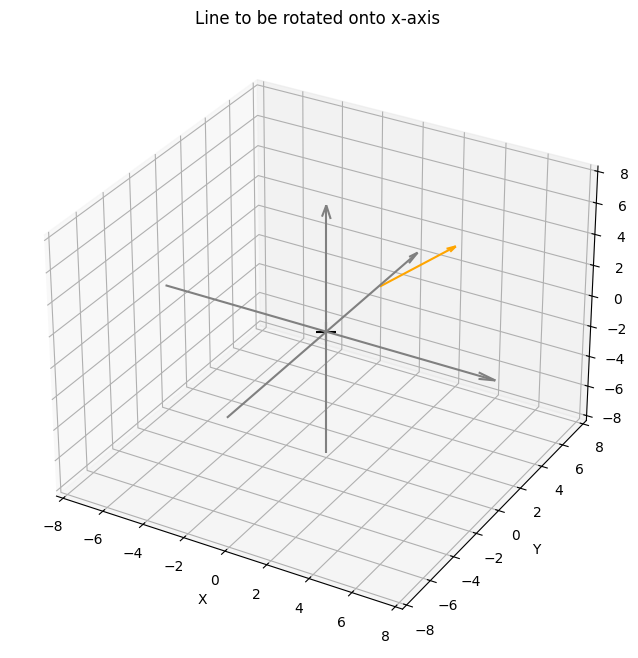

In [4]:
# Creation of figure and subplot for plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Setting the title
plt.title('Line to be rotated onto x-axis')

# Origin - as black Plus/ Cross
ax.scatter(xs=0,
    ys=0,
    zs=0,
    marker='+', 
    c='black', 
    s=200)

# Axes - as quivers in grey
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                    y_vec, 
                    z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
        arrow_length_ratio=0.05, 
        color='grey')

# Painting the vector
ax.quiver(vector_start[0],
          vector_start[1],
          vector_start[2],
          vector[0], 
          vector[1], 
          vector[2], 
          arrow_length_ratio=0.1, 
          color='orange')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


## Rotation

Now that we have the vector which shall be rotated and we also know the unit vector of the axis onto which it shall be rotated, we can create the rotation matrix, which completes the wanted rotation and also finally rotate the vector.

In [5]:
# Retrieving rotation matrix
R = rot_mat_from_vecs(vector, np.array([1, 0, 0]))

# Rotating the vector
vector_rotated = R.dot(vector)

### Visualization of the rotation

Below you can find a visualization of the original vector (blue) and the rotated vector (red), which shuold now align in directionality with/ be parallel to the x-axis.

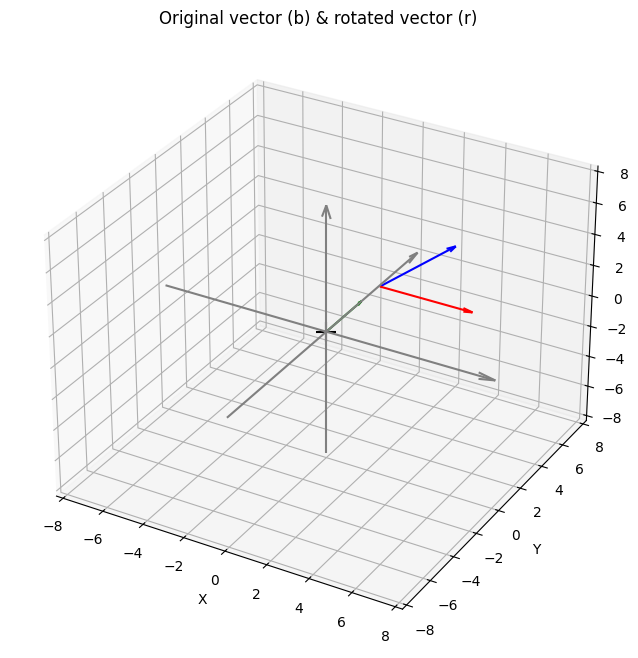

In [6]:
# Creation of figure and subplot for plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Setting the title
plt.title('Original vector (b) & rotated vector (r)')

# Origin - as black Plus/ Cross
ax.scatter(xs=0,
    ys=0,
    zs=0,
    marker='+', 
    c='black', 
    s=200)

# Axes - as quivers in grey
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                    y_vec, 
                    z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
        arrow_length_ratio=0.05, 
        color='grey')

# Painting the original vector
ax.quiver(vector_start[0],
          vector_start[1],
          vector_start[2],
          vector[0], 
          vector[1], 
          vector[2], 
          arrow_length_ratio=0.1, 
          color='blue')

# Painting the vector to be aligned with
ax.quiver(0,
          0,
          0,
          0, 
          3, 
          0, 
          arrow_length_ratio=0.1, 
          color='green')

# Painting the rotated vector
ax.quiver(vector_start[0],
          vector_start[1],
          vector_start[2],
          vector_rotated[0], 
          vector_rotated[1], 
          vector_rotated[2], 
          arrow_length_ratio=0.1, 
          color='red')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

# Orthonormal Vector Trio Rotation

After the sucessful test rotation of a single vector onto the x-axis, we will now test the rotation procedure on not only a single vector but on an orthonormal vector trio to be aligned with the axes.

## Orthonormal vector trio definition

The main importance to have in mind for the definition of the respective x-, y- and z-edge vectors of the bounding box is that their lenght is ordered. Meaning the x-edge shall be the longest edge, while the z-edge shall be the shortest. Therefore, below you can find the respective edge vector definitions with the lengths set so the ordinality of this relationship is true. Additionally, the rotation angles by which the orthonormal vector trio is rotated can be adjusted below as well under theta1, theta2 and theta3.

In [7]:
# Definition of orthonormal vector trio (alongside axeses)
x_edge = np.array([6, 0, 0])
y_edge = np.array([0, 4, 0])
z_edge = np.array([0, 0, 2])
orthonormal_edges_coords = np.vstack([x_edge, y_edge, z_edge])

# Definition of rotation angles
theta1, theta2, theta3 = 30, 15, 20

# Creation of rotation matrices
Rx = create_rot_mat(theta1, 'x')
Ry = create_rot_mat(theta2, 'y')
Rz = create_rot_mat(theta3, 'z')
R = combine_rot_mats(Rx, Ry, Rz)

# Applying rotation 
orthonormal_edges_coords_rot = rotate(orthonormal_edges_coords, R)

# Definition of the translation vector
translation_vec = np.array([2, 1, 4])

# Translation
orthonormal_edges_coords_rot_tran = translate_coords(orthonormal_edges_coords_rot, translation_vec)

### Visualization of orthonormal vector trio

In order to make sure the orthonormal vector trio was defined and rotated correctly, below you can find a small visualization showcasing the edge vectors in their respective color (x: red, y: blue and z: green).

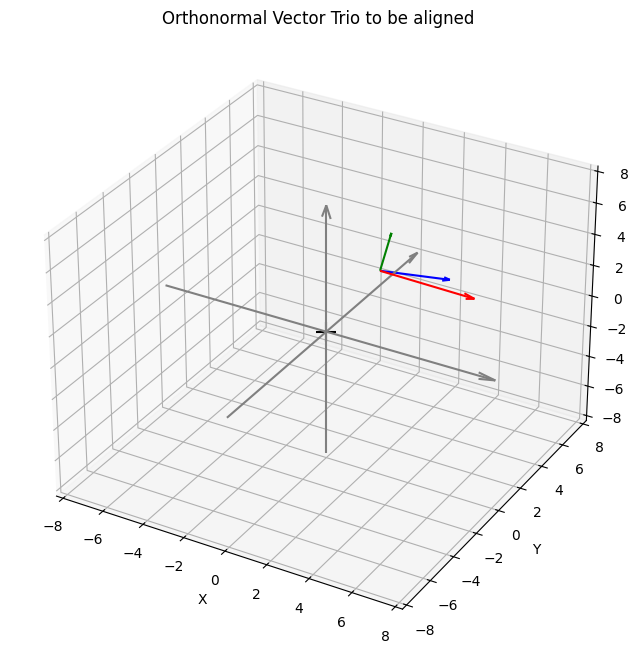

In [9]:
# Creation of figure and subplot for plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Setting the title
plt.title('Orthonormal Vector Trio to be aligned')

# Origin - as black Plus/ Cross
ax.scatter(xs=0,
    ys=0,
    zs=0,
    marker='+', 
    c='black', 
    s=200)

# Axes - as quivers in grey
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                    y_vec, 
                    z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
        arrow_length_ratio=0.05, 
        color='grey')

# Painting the x-edge
ax.quiver(translation_vec[0],
          translation_vec[1],
          translation_vec[2],
          orthonormal_edges_coords_rot[0][0], 
          orthonormal_edges_coords_rot[0][1], 
          orthonormal_edges_coords_rot[0][2], 
          arrow_length_ratio=0.1, 
          color='red')

# Painting the y-edge
ax.quiver(translation_vec[0],
          translation_vec[1],
          translation_vec[2],
          orthonormal_edges_coords_rot[1][0], 
          orthonormal_edges_coords_rot[1][1], 
          orthonormal_edges_coords_rot[1][2],
          arrow_length_ratio=0.1, 
          color='blue')

# Painting the rotated vector
ax.quiver(translation_vec[0],
          translation_vec[1],
          translation_vec[2],
          orthonormal_edges_coords_rot[2][0], 
          orthonormal_edges_coords_rot[2][1], 
          orthonormal_edges_coords_rot[2][2], 
          arrow_length_ratio=0.1, 
          color='green')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## First Backrotation/ Alignment

For the first rotation we will align the z-edge of the imaginary bounding box with the z-axis.

In [10]:
# Retrieving rotation matrix
R = rot_mat_from_vecs(orthonormal_edges_coords_rot[2], np.array([0, 0, 1]))

# Rotating all vectors
orthonormal_edges_coords_back_rot1_list = [] 
for i in range(len(orthonormal_edges_coords_rot)):
    orthonormal_edge_i_coords_back_rot1 = R.dot(orthonormal_edges_coords_rot[i])
    orthonormal_edges_coords_back_rot1_list.append(orthonormal_edge_i_coords_back_rot1)
orthonormal_edges_coords_back_rot1 = np.array(orthonormal_edges_coords_back_rot1_list)

### Visualization of first back rotation

In order to also visually double-check, below you can find a small visualization showcasing the first rotation, by which we rotate the orthonormal vector trio's shortest vector - the z-edge - to the same orientation as the z-axis. Therefore, the green edge of the bounding box vector trio should be parallel to the z-axis.

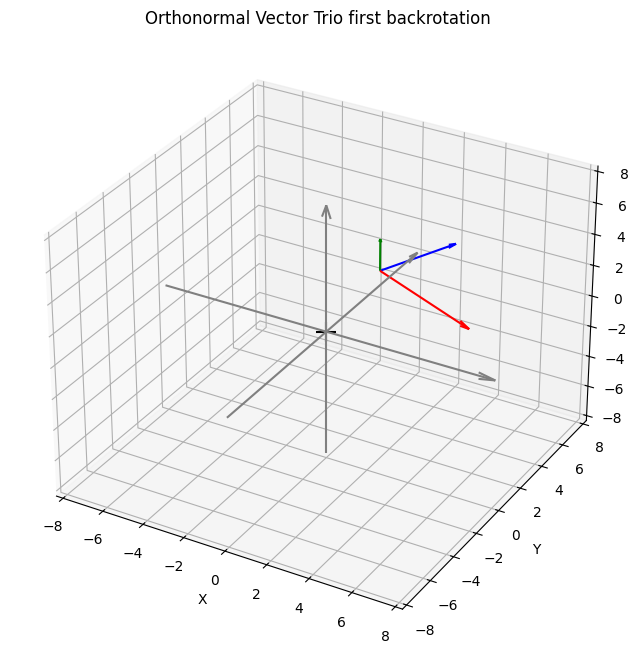

In [12]:
# Creation of figure and subplot for plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Setting the title
plt.title('Orthonormal Vector Trio first backrotation')

# Origin - as black Plus/ Cross
ax.scatter(xs=0,
    ys=0,
    zs=0,
    marker='+', 
    c='black', 
    s=200)

# Axes - as quivers in grey
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                    y_vec, 
                    z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
        arrow_length_ratio=0.05, 
        color='grey')

# Painting the x-edge
ax.quiver(translation_vec[0],
          translation_vec[1],
          translation_vec[2],
          orthonormal_edges_coords_back_rot1[0][0], 
          orthonormal_edges_coords_back_rot1[0][1], 
          orthonormal_edges_coords_back_rot1[0][2], 
          arrow_length_ratio=0.1, 
          color='red')

# Painting the y-edge
ax.quiver(translation_vec[0],
          translation_vec[1],
          translation_vec[2],
          orthonormal_edges_coords_back_rot1[1][0], 
          orthonormal_edges_coords_back_rot1[1][1], 
          orthonormal_edges_coords_back_rot1[1][2],
          arrow_length_ratio=0.1, 
          color='blue')

# Painting the rotated vector
ax.quiver(translation_vec[0],
          translation_vec[1],
          translation_vec[2],
          orthonormal_edges_coords_back_rot1[2][0], 
          orthonormal_edges_coords_back_rot1[2][1], 
          orthonormal_edges_coords_back_rot1[2][2], 
          arrow_length_ratio=0.1, 
          color='green')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Second Backrotation/ Alignment

For the second rotation we will attempt at aligning the longest x-edge with the x-axis, to get to full alignment.

In [55]:
# Retrieving rotation matrix
R = rot_mat_from_vecs(orthonormal_edges_coords_back_rot1[0], np.array([1, 0, 0]))

# Rotating all vectors
orthonormal_edges_coords_back_rot2_list = [] 
for i in range(len(orthonormal_edges_coords_back_rot1)):
    orthonormal_edge_i_coords_back_rot2 = R.dot(orthonormal_edges_coords_back_rot1[i])
    orthonormal_edges_coords_back_rot2_list.append(orthonormal_edge_i_coords_back_rot2)
orthonormal_edges_coords_back_rot2 = np.array(orthonormal_edges_coords_back_rot2_list)

### Visualization of second backrotation

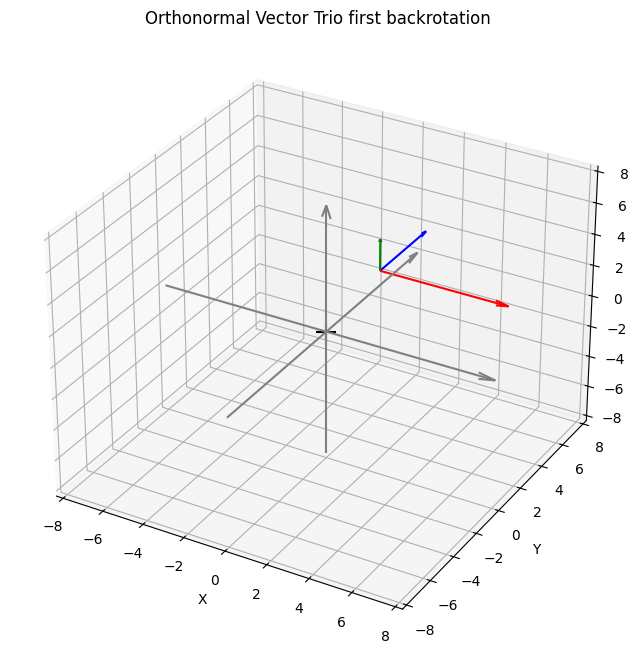

In [56]:
# Creation of figure and subplot for plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Setting the title
plt.title('Orthonormal Vector Trio first backrotation')

# Origin - as black Plus/ Cross
ax.scatter(xs=0,
    ys=0,
    zs=0,
    marker='+', 
    c='black', 
    s=200)

# Axes - as quivers in grey
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                    y_vec, 
                    z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
        arrow_length_ratio=0.05, 
        color='grey')

# Painting the x-edge
ax.quiver(translation_vec[0],
          translation_vec[1],
          translation_vec[2],
          orthonormal_edges_coords_back_rot2[0][0], 
          orthonormal_edges_coords_back_rot2[0][1], 
          orthonormal_edges_coords_back_rot2[0][2], 
          arrow_length_ratio=0.1, 
          color='red')

# Painting the y-edge
ax.quiver(translation_vec[0],
          translation_vec[1],
          translation_vec[2],
          orthonormal_edges_coords_back_rot2[1][0], 
          orthonormal_edges_coords_back_rot2[1][1], 
          orthonormal_edges_coords_back_rot2[1][2],
          arrow_length_ratio=0.1, 
          color='blue')

# Painting the rotated vector
ax.quiver(translation_vec[0],
          translation_vec[1],
          translation_vec[2],
          orthonormal_edges_coords_back_rot2[2][0], 
          orthonormal_edges_coords_back_rot2[2][1], 
          orthonormal_edges_coords_back_rot2[2][2], 
          arrow_length_ratio=0.1, 
          color='green')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

# Conclusion

Both the rotation alignment of the single vector as well as the alignment for the vector trio worked as wished for. Therefore, the next test will be to do the exact same alignment with the randomly rotated and translated cuboid, before we go on to test this for the actual point cloud bounding box.
Also, one thing to keep in the back of the head, in the special case of initial alignment (meaning the edge are already parallell to the axis), we might need to adjust the formula, as it then might produce unwanted results.